In [1]:
# imports
import os
import random
from scipy.io import wavfile

# from python_speech_features import mfcc
from sklearn import preprocessing
import librosa
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from pydub import AudioSegment
import math
import statistics
import soundfile as sf
import glob
import torch
import shutil

import warnings

warnings.filterwarnings("ignore", category=wavfile.WavFileWarning)
warnings.filterwarnings("ignore", category=UserWarning)

/home/mstrouse/448/project/gatedConformer/env/lib/python3.11/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


Confirm running on gpu. Device should be "cuda"

In [2]:
use_cpu = False

if torch.cuda.is_available() and not use_cpu:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Device:", device)

Device: cuda


Filepaths below. Delete folders if changing data. Old data won't be automatically deleted from folders

In [3]:
mssnsd_ac_raw = os.path.join("rawdata/MSSNSD_ac")
mssnsd_ac_split = os.path.join("rawdata/MSSNSD_ac_split")

mssnsd_babble_raw = os.path.join("rawdata/MSSNSD_babble")
mssnsd_babble_split = os.path.join("rawdata/MSSNSD_babble_split")

bed = os.path.join("rawdata/BED")
cremad = os.path.join("rawdata/CREMAD")
ravdess = os.path.join("rawdata/RAVDESS")

bed_train = os.path.join("rawtraintestdata/bed_train")
bed_testseen = os.path.join("rawtraintestdata/bed_testseen")
bed_testunseen = os.path.join("rawtraintestdata/bed_testunseen")

cremad_train = os.path.join("rawtraintestdata/cremad_train")
cremad_testseen = os.path.join("rawtraintestdata/cremad_testseen")
cremad_testunseen = os.path.join("rawtraintestdata/cremad_testunseen")

ravdess_train = os.path.join("rawtraintestdata/ravdess_train")
ravdess_testseen = os.path.join("rawtraintestdata/ravdess_testseen")
ravdess_testunseen = os.path.join("rawtraintestdata/ravdess_testunseen")

ac_train = os.path.join("rawtraintestdata/ac_train")
ac_test = os.path.join("rawtraintestdata/ac_test")

babble_train = os.path.join("rawtraintestdata/babble_train")
babble_test = os.path.join("rawtraintestdata/babble_test")

noisy_bed_train = os.path.join("noisydata/noisy_bed_train")
noisy_bed_testseen = os.path.join("noisydata/noisy_bed_testseen")
noisy_bed_testunseen = os.path.join("noisydata/noisy_bed_testunseen")

noisy_cremad_train = os.path.join("noisydata/noisy_cremad_train")
noisy_cremad_testseen = os.path.join("noisydata/noisy_cremad_testseen")
noisy_cremad_testunseen = os.path.join("noisydata/noisy_cremad_testunseen")

noisy_ravdess_train = os.path.join("noisydata/noisy_ravdess_train")
noisy_ravdess_testseen = os.path.join("noisydata/noisy_ravdess_testseen")
noisy_ravdess_testunseen = os.path.join("noisydata/noisy_ravdess_testunseen")

noisy_ac_train = os.path.join("noisydata/noisy_ac_train")
noisy_ac_test = os.path.join("noisydata/noisy_ac_test")

noisy_babble_train = os.path.join("noisydata/noisy_babble_train")
noisy_babble_test = os.path.join("noisydata/noisy_babble_test")

Check minimum size of mssnsd data below

In [4]:
total_len = 0
file_count = 0
min_size = 0
first_file = True
for file in tqdm(os.listdir(mssnsd_ac_raw), desc="MSSNSD AC Progress"):
    file_path = os.path.join(mssnsd_ac_raw, file)
    audio = AudioSegment.from_wav(file_path)
    if first_file:
        min_size = len(audio)
        first_file = False
    if len(audio) < min_size:
        min_size = len(audio)
    total_len += len(audio)
    file_count += 1
print(f"Minimum ms for mssnsd AC: {min_size}")
print(f"Number of mssnsd AC files: {file_count}")
print(f"Total ms of mssnsd AC files: {total_len}")

total_len = 0
file_count = 0
min_size = 0
first_file = True
for file in tqdm(os.listdir(mssnsd_babble_raw), desc="MSSNSD Babble Progress"):
    file_path = os.path.join(mssnsd_babble_raw, file)
    audio = AudioSegment.from_wav(file_path)
    if first_file:
        min_size = len(audio)
        first_file = False
    if len(audio) < min_size:
        min_size = len(audio)
    total_len += len(audio)
    file_count += 1
print(f"Minimum ms for mssnsd Babble: {min_size}")
print(f"Number of mssnsd Babble files: {file_count}")
print(f"Total ms of mssnsd Babble files: {total_len}")

MSSNSD AC Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Minimum ms for mssnsd AC: 20355
Number of mssnsd AC files: 20
Total ms of mssnsd AC files: 850806


MSSNSD Babble Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Minimum ms for mssnsd Babble: 21460
Number of mssnsd Babble files: 20
Total ms of mssnsd Babble files: 1237154


Split background noise done below in 3.6 second clips. Can do air conditioning or babble. Minimum length from above is 20.36 seconds for mssnsd AC and 21.46 seconds for mssnsd Babble, so we do not have to be worried about a clip being too short.

In [5]:
new_wav_length = 3600

def split_wav_file(group, path, outpath, desired_length):
    audio = AudioSegment.from_wav(path)
    new_files = len(audio) // desired_length
    for i in range(new_files):
        starting_ms = i * desired_length
        ending_ms = starting_ms + desired_length
        new_file = audio[starting_ms:ending_ms]
        new_filename = f"{group}_{i}.wav"
        new_path = os.path.join(outpath, new_filename)
        new_file.export(new_path, format="wav")


for file in tqdm(os.listdir(mssnsd_babble_raw), desc="Babble Split Progress"):
    group = file.split(".")[0]
    path = os.path.join(mssnsd_babble_raw, file)
    split_wav_file(group, path, mssnsd_babble_split, new_wav_length)

for file in tqdm(os.listdir(mssnsd_ac_raw), desc="AC Split Progress"):
    group = file.split(".")[0]
    path = os.path.join(mssnsd_ac_raw, file)
    split_wav_file(group, path, mssnsd_ac_split, new_wav_length)

Babble Split Progress:   0%|          | 0/20 [00:00<?, ?it/s]

AC Split Progress:   0%|          | 0/20 [00:00<?, ?it/s]

To normalize the emotion labels across the datasets, we are going standardize the labels to anger, disgust, fear, happy, sad, neutral

In [6]:
BED_speaker_list = ["03", "08", "09", "10", "11", "12", "13", "14", "15", "16"]
CREMA_speaker_list = [
    "1033",
    "1001",
    "1056",
    "1077",
    "1086",
    "1079",
    "1014",
    "1024",
    "1062",
    "1027",
    "1080",
    "1065",
    "1051",
    "1083",
    "1060",
    "1011",
    "1073",
    "1019",
    "1041",
    "1048",
    "1052",
    "1063",
    "1066",
    "1020",
    "1004",
    "1038",
    "1022",
    "1059",
    "1037",
    "1044",
    "1002",
    "1054",
    "1032",
    "1003",
    "1082",
    "1053",
    "1068",
    "1072",
    "1029",
    "1026",
    "1034",
    "1005",
    "1069",
    "1023",
    "1040",
    "1081",
    "1036",
    "1017",
    "1043",
    "1008",
    "1012",
    "1087",
    "1031",
    "1010",
    "1064",
    "1013",
    "1070",
    "1028",
    "1018",
    "1035",
    "1057",
    "1030",
    "1015",
    "1061",
    "1016",
    "1067",
    "1007",
    "1085",
    "1075",
    "1071",
    "1047",
    "1089",
    "1050",
    "1021",
    "1009",
    "1055",
    "1088",
    "1076",
    "1058",
    "1049",
    "1045",
    "1091",
    "1078",
    "1042",
    "1046",
    "1039",
    "1025",
    "1074",
    "1084",
    "1090",
    "1006",
]
RAVDESS_speaker_list = [
    "01",
    "02",
    "03",
    "04",
    "05",
    "06",
    "07",
    "08",
    "09",
    "10",
    "11",
    "12",
    "13",
    "14",
    "15",
    "16",
    "17",
    "18",
    "19",
    "20",
    "21",
    "22",
    "23",
    "24",
]


# removed boredom
def createBEDSpeakerMap():
    german_to_eng_emotion = {
        "W": "Anger",
        "E": "Disgust",
        "A": "Fear",
        "F": "Happy",
        "N": "Neutral",
        "T": "Sad",
    }
    speaker_map = {}
    for speaker in BED_speaker_list:
        speaker_map[speaker] = [[], []]
    for file in os.listdir(bed):
        if file.endswith(".wav"):
            speaker = file[:2]
            german_emotion = file[5]
            if german_emotion in german_to_eng_emotion:
                emotion = german_to_eng_emotion[german_emotion]
                full_filename = os.path.join(file)
                speaker_map[speaker][0].append(full_filename)
                speaker_map[speaker][1].append(emotion)
    return speaker_map


def createCREMADSpeakerMap():
    file_to_eng_emotion = {
        "SAD": "Sad",
        "ANG": "Anger",
        "DIS": "Disgust",
        "FEA": "Fear",
        "HAP": "Happy",
        "NEU": "Neutral",
    }
    speaker_map = {}
    for speaker in CREMA_speaker_list:
        speaker_map[speaker] = [[], []]
    for file in os.listdir(cremad):
        if file.endswith(".wav"):
            parts = file.split("_")
            speaker = parts[0]
            file_emotion = parts[2]
            emotion = file_to_eng_emotion[file_emotion]
            speaker_map[speaker][0].append(file)
            speaker_map[speaker][1].append(emotion)
    return speaker_map


# removed calm and surprised
def createRAVDESSSpeakerMap():
    file_to_eng_emotion = {
        "01": "Neutral",
        "03": "Happy",
        "04": "Sad",
        "05": "Anger",
        "06": "Fear",
        "07": "Disgust",
    }
    speaker_map = {}
    for speaker in RAVDESS_speaker_list:
        speaker_map[speaker] = [[], []]
    for file in os.listdir(ravdess):
        if file.endswith(".wav"):
            parts = file.split("-")
            speaker = parts[6].split(".")[0][:2]
            file_emotion = parts[2]
            if file_emotion in file_to_eng_emotion:
                emotion = file_to_eng_emotion[file_emotion]
                speaker_map[speaker][0].append(file)
                speaker_map[speaker][1].append(emotion)
    return speaker_map

In [7]:
emotions = ["Sad", "Anger", "Disgust", "Fear", "Happy", "Neutral"]

BED_holdout_speakers = ["11", "16"]
CREMA_holdout_speakers = [
    "1085",
    "1012",
    "1041",
    "1009",
    "1010",
    "1037",
    "1061",
    "1024",
    "1018",
    "1008",
    "1017",
    "1082",
    "1053",
    "1048",
    "1026",
    "1059",
    "1023",
    "1032",
]
RAVDESS_holdout_speakers = ["14", "03", "16", "06", "18"]


def split_data(speakers, speaker_map, holdout_speakers):
    random.seed(12)
    train_data = {}
    test_seen_speakers = {}
    test_unseen_speakers = {}

    for emotion in emotions:
        train_data[emotion] = []
        test_seen_speakers[emotion] = []
        test_unseen_speakers[emotion] = []

    for speaker in speakers:
        if speaker not in holdout_speakers:
            # Use 20% of the speaker's data in the test set if not holdout
            test_count = int(0.2 * len(speaker_map[speaker][0]))
            test_indices = random.sample(
                list(range(0, len(speaker_map[speaker][0]))), test_count
            )
            for i in range(len(speaker_map[speaker][1])):
                if i in test_indices:
                    test_seen_speakers[speaker_map[speaker][1][i]].append(
                        speaker_map[speaker][0][i]
                    )
                else:
                    train_data[speaker_map[speaker][1][i]].append(
                        speaker_map[speaker][0][i]
                    )
        else:
            for i in range(len(speaker_map[speaker][1])):
                test_unseen_speakers[speaker_map[speaker][1][i]].append(
                    speaker_map[speaker][0][i]
                )

    return train_data, test_seen_speakers, test_unseen_speakers


BED_train, BED_testseen, BED_testunseen = split_data(
    BED_speaker_list, createBEDSpeakerMap(), BED_holdout_speakers
)
CREMA_train, CREMA_testseen, CREMA_testunseen = split_data(
    CREMA_speaker_list, createCREMADSpeakerMap(), CREMA_holdout_speakers
)
RAVDESS_train, RAVDESS_testseen, RAVDESS_testunseen = split_data(
    RAVDESS_speaker_list, createRAVDESSSpeakerMap(), RAVDESS_holdout_speakers
)

Unlike the speech datasets which have different speakers and thus can have a test seen and test unseen, we will only get train and test from mssnsd

In [8]:
def split_background_data():
    random.seed(12)
    data = []
    for file in os.listdir(mssnsd_ac_split):
        data.append(file)

    train_data = {}
    test_data = {}
    train_data["Background"] = []
    test_data["Background"] = []

    # Use 20% of the groups's data in the test set if not holdout
    test_count = int(0.2 * len(data))
    test_indices = random.sample(list(range(0, len(data))), test_count)
    for i in range(len(data)):
        if i in test_indices:
            test_data["Background"].append(data[i])
        else:
            train_data["Background"].append(data[i])

    return train_data, test_data

MSSNSD_train, MSSNSD_testseen = split_background_data()

Copy files into train, test seen, test unseen folders before making the data noisy. This is to make sure no background noise will be in both the train or test data

In [9]:
def copyfiles(set, source_dir, dest_dir):
    os.makedirs(dest_dir, exist_ok=True)
    for emotion in set:
        for file in set[emotion]:
            source = os.path.join(source_dir, file)
            destination = os.path.join(dest_dir)
            shutil.copy(source, destination)

copyfiles(BED_train, bed, bed_train)
copyfiles(BED_testseen, bed, bed_testseen)
copyfiles(BED_testunseen, bed, bed_testunseen)
copyfiles(CREMA_train, cremad, cremad_train)
copyfiles(CREMA_testseen, cremad, cremad_testseen)
copyfiles(CREMA_testunseen, cremad, cremad_testunseen)
copyfiles(RAVDESS_train, ravdess, ravdess_train)
copyfiles(RAVDESS_testseen, ravdess, ravdess_testseen)
copyfiles(RAVDESS_testunseen, ravdess, ravdess_testunseen)
# change background type here
copyfiles(MSSNSD_train, mssnsd_ac_split, ac_train)
copyfiles(MSSNSD_testseen, mssnsd_ac_split, ac_test)

Surrounding and overlapping clean speech utterances with background noise.

In [17]:
# source - https://github.com/microsoft/MS-SNSD

# vars for mixing & making noisy speech, can change
sampling_rate = 16000
audio_length = 10
silence_length = 0.5
total_hours = 1
snr_lower = 20
snr_upper = 30
total_snrlevels = 2
total_snrlevels_noise_only = 20
noise_types_excluded = 'None'

# Function to read audio
def audioread(path, norm=True, start=0, stop=None, target_sr=16000):
    path = os.path.abspath(path)
    if not os.path.exists(path):
        raise ValueError("[{}] does not exist!".format(path))
    try:
        x, sr = sf.read(path, start=start, stop=stop)
        if sr != target_sr:
            x = librosa.resample(x, orig_sr=sr, target_sr=target_sr)
            sr = target_sr
    except RuntimeError:  # fix for sph pcm-embedded shortened v2
        print("WARNING: Audio type not supported")

    if len(x.shape) == 1:  # mono
        if norm:
            rms = (x**2).mean() ** 0.5
            scalar = 10 ** (-25 / 20) / (rms)
            x = x * scalar
        return x, sr
    else:  # multi-channel
        x = x.T
        x = x.sum(axis=0) / x.shape[0]
        if norm:
            rms = (x**2).mean() ** 0.5
            scalar = 10 ** (-25 / 20) / (rms)
            x = x * scalar
        return x, sr


# Function to write audio
eps = 1e-8
def audiowrite(data, fs, destpath, norm=False):
    if norm:
        rms = (data**2).mean() ** 0.5
        scalar = 10 ** (-25 / 10) / (rms + eps)
        data = data * scalar
        if max(abs(data)) >= 1:
            data = data / max(abs(data), eps)

    destpath = os.path.abspath(destpath)
    destdir = os.path.dirname(destpath)

    if not os.path.exists(destdir):
        os.makedirs(destdir)

    sf.write(destpath, data, fs)
    return


# Function to mix clean speech and noise at various SNR levels
def snr_mixer(clean, noise, snr):
    # Normalizing to -25 dB FS
    rmsclean = (clean**2).mean() ** 0.5
    scalarclean = 10 ** (-25 / 20) / rmsclean
    clean = clean * scalarclean
    rmsclean = (clean**2).mean() ** 0.5

    rmsnoise = (noise**2).mean() ** 0.5
    scalarnoise = 10 ** (-25 / 20) / rmsnoise
    noise = noise * scalarnoise
    rmsnoise = (noise**2).mean() ** 0.5

    # Set the noise level for a given SNR
    noisescalar = np.sqrt(rmsclean / (10 ** (snr / 20)) / rmsnoise)
    noisenewlevel = noise * noisescalar
    noisyspeech = clean + noisenewlevel
    return clean, noisenewlevel, noisyspeech


def make_noisy(clean_dir, noise_dir, noisyspeech_dir, fs, dataset):
    total_secs = total_hours * 60 * 60
    # total_samples = int(total_secs * fs)
    # audio_length = int(audio_length * fs)
    # SNR = np.linspace(snr_lower, snr_upper, total_snrlevels)
    cleanfilenames = glob.glob(os.path.join(clean_dir, "*.wav"))
    if noise_types_excluded == "None":
        noisefilenames = glob.glob(os.path.join(noise_dir, "*.wav"))
    else:
        noisefilenames = glob.glob(os.path.join(noise_dir, "*.wav"))
        for i in range(len(noise_types_excluded)):
            noisefilenames = [
                fn
                for fn in noisefilenames
                if not os.path.basename(fn).startswith(noise_types_excluded[i])
            ]

    for idx_s, clean_filename in tqdm(enumerate(cleanfilenames), desc=f"{dataset} noisy progress"):
        clean, fs = audioread(clean_filename)  # Read the clean speech file
        # Add silence to the beginning and end, if required (convert seconds to samples)
        silence = np.zeros(int(silence_length * fs))
        clean_with_silence = np.concatenate([silence, clean, silence])
        # print("fs:", fs, "silence_length:", silence_length," silence:",silence, " clean_with_silence:", clean_with_silence)

        # Randomly select a noise file
        noise_filename = random.choice(noisefilenames)
        noise, fs = audioread(noise_filename)  # Read the noise file

        # If the noise is shorter than the clean speech, loop it; if it's longer, trim it
        if len(noise) < len(clean_with_silence):
            noise = np.tile(noise, int(np.ceil(len(clean_with_silence) / len(noise))))
        noise = noise[
            : len(clean_with_silence)
        ]  # Trim the noise to match the clean speech length

        # comment out below if not debugging
        # print(f"Clean file {clean_filename}: {len(clean) / fs} seconds")
        # print(f"Clean file with silence: {len(clean_with_silence) / fs} seconds")
        # print(f"Noise file {noise_filename}: {len(noise) / fs} seconds")

        # Mix the clean_with_silence and noise at various SNR levels and write to their respective directories
        for snr in np.linspace(snr_lower, snr_upper, total_snrlevels):
            _, _, noisy_snr = snr_mixer(clean_with_silence, noise, snr)

            file_name_only = os.path.basename(clean_filename)
            filename_without_extension, extension = os.path.splitext(file_name_only)

            noisyfilename = f"{filename_without_extension}_noisy{idx_s}_SNRdb_{snr}_clnsp{idx_s}.wav"

            # Derive the full paths for the output files
            noisypath = os.path.join(noisyspeech_dir, noisyfilename)

            # Write the output files
            audiowrite(noisy_snr, fs, noisypath, norm=False)
    return

def get_levels(noise_dir, output_dir):
    noisefiles = glob.glob(os.path.join(noise_dir, "*.wav"))
    for file in noisefiles:
        data, fs = audioread(file)
        for snr in np.linspace(snr_lower, snr_upper, total_snrlevels_noise_only):
            _, new_noise, _ = snr_mixer(data, data, snr)
            file_name_only = os.path.basename(file)
            filename_without_extension, extension = os.path.splitext(file_name_only)
            newfilename = f"{filename_without_extension}_noisy_SNRdb_{snr}.wav"
            path = os.path.join(output_dir, newfilename)
            audiowrite(new_noise, fs, path, norm=False)


# change background noise type here
# make_noisy(bed_train, ac_train, noisy_bed_train, sampling_rate, "bed_train")
# make_noisy(bed_testseen, ac_train, noisy_bed_testseen, sampling_rate, "bed_testseen")
# make_noisy(
#     bed_testunseen,
#     ac_train,
#     noisy_bed_testunseen,
#     sampling_rate,
#     "bed_testunseen",
# )
# make_noisy(
#     cremad_train, ac_train, noisy_cremad_train, sampling_rate, "cremad_train"
# )
# make_noisy(
#     cremad_testseen,
#     ac_train,
#     noisy_cremad_testseen,
#     sampling_rate,
#     "cremad_testseen",
# )
# make_noisy(
#     cremad_testunseen,
#     ac_train,
#     noisy_cremad_testunseen,
#     sampling_rate,
#     "cremad_testunseen",
# )
# make_noisy(
#     ravdess_train, ac_train, noisy_ravdess_train, sampling_rate, "ravdess_train"
# )
# make_noisy(
#     ravdess_testseen,
#     ac_train,
#     noisy_ravdess_testseen,
#     sampling_rate,
#     "ravdess_testseen",
# )
# make_noisy(
#     ravdess_testunseen,
#     ac_train,
#     noisy_ravdess_testunseen,
#     sampling_rate,
#     "ravdess_testunseen",
# )

# # gets the same noise levels that are used for the speech data for noise by itself
# get_levels(ac_train, noisy_ac_train)
# get_levels(ac_test, noisy_ac_test)

In [9]:
folders = [noisy_bed_train, noisy_bed_testseen, noisy_bed_testunseen, noisy_cremad_train, noisy_cremad_testseen, noisy_cremad_testunseen, noisy_ravdess_train, noisy_ravdess_testseen, noisy_ravdess_testunseen, noisy_ac_train, noisy_ac_test]

total_ms = 0
file_count = 0
for folder in folders:
    for file in tqdm(os.listdir(folder), desc=f"{folder}progress"):
        file_path = os.path.join(folder, file)
        audio = AudioSegment.from_wav(file_path)
        total_ms += len(audio)
        file_count += 1
print(f"Average ms: {total_ms / file_count}")

noisydata/noisy_bed_trainprogress:   0%|          | 0/566 [00:00<?, ?it/s]

noisydata/noisy_bed_testseenprogress:   0%|          | 0/134 [00:00<?, ?it/s]

noisydata/noisy_bed_testunseenprogress:   0%|          | 0/208 [00:00<?, ?it/s]

noisydata/noisy_cremad_trainprogress:   0%|          | 0/9622 [00:00<?, ?it/s]

noisydata/noisy_cremad_testseenprogress:   0%|          | 0/2334 [00:00<?, ?it/s]

noisydata/noisy_cremad_testunseenprogress:   0%|          | 0/2928 [00:00<?, ?it/s]

noisydata/noisy_ravdess_trainprogress:   0%|          | 0/1368 [00:00<?, ?it/s]

noisydata/noisy_ravdess_testseenprogress:   0%|          | 0/304 [00:00<?, ?it/s]

noisydata/noisy_ravdess_testunseenprogress:   0%|          | 0/440 [00:00<?, ?it/s]

noisydata/noisy_ac_trainprogress:   0%|          | 0/3620 [00:00<?, ?it/s]

noisydata/noisy_ac_testprogress:   0%|          | 0/900 [00:00<?, ?it/s]

Average ms: 3676.442561541206


Reset dictionaries below

In [10]:
def set_bed_dict(path):
    files_by_emotion = {}
    german_to_eng_emotion = {
        "W": "Anger",
        "E": "Disgust",
        "A": "Fear",
        "F": "Happy",
        "N": "Neutral",
        "T": "Sad",
    }
    for _, emotion in german_to_eng_emotion.items():
        files_by_emotion[emotion] = []
    for file in os.listdir(path):
        if file.endswith(".wav"):
            german_emotion = file[5]
            if german_emotion in german_to_eng_emotion:
                emotion = german_to_eng_emotion[german_emotion]
                full_filename = os.path.join(file)
                files_by_emotion[emotion].append(full_filename)
    return files_by_emotion

def set_cremad_dict(path):
    files_by_emotion = {}
    file_to_eng_emotion = {
        "SAD": "Sad",
        "ANG": "Anger",
        "DIS": "Disgust",
        "FEA": "Fear",
        "HAP": "Happy",
        "NEU": "Neutral",
    }
    for _, emotion in file_to_eng_emotion.items():
        files_by_emotion[emotion] = []
    for file in os.listdir(path):
        if file.endswith(".wav"):
            parts = file.split("_")
            file_emotion = parts[2]
            emotion = file_to_eng_emotion[file_emotion]
            full_filename = os.path.join(file)
            files_by_emotion[emotion].append(full_filename)
    return files_by_emotion

def set_ravdess_dict(path):
    files_by_emotion = {}
    file_to_eng_emotion = {
        "01": "Neutral",
        "03": "Happy",
        "04": "Sad",
        "05": "Anger",
        "06": "Fear",
        "07": "Disgust",
    }
    for _, emotion in file_to_eng_emotion.items():
        files_by_emotion[emotion] = []
    for file in os.listdir(path):
        if file.endswith(".wav"):
            parts = file.split("-")
            file_emotion = parts[2]
            if file_emotion in file_to_eng_emotion:
                emotion = file_to_eng_emotion[file_emotion]
                full_filename = os.path.join(file)
                files_by_emotion[emotion].append(full_filename)
    return files_by_emotion

def set_mssnsd_dict(path):
    files = {'Background': []}
    for file in os.listdir(path):
        full_filename = os.path.join(file)
        files['Background'].append(full_filename)
    return files

BED_train = set_bed_dict(noisy_bed_train)
BED_testseen = set_bed_dict(noisy_bed_testseen)
BED_testunseen = set_bed_dict(noisy_bed_testunseen)
CREMA_train = set_cremad_dict(noisy_cremad_train)
CREMA_testseen = set_cremad_dict(noisy_cremad_testseen)
CREMA_testunseen = set_cremad_dict(noisy_cremad_testunseen)
RAVDESS_train = set_ravdess_dict(noisy_ravdess_train)
RAVDESS_testseen = set_ravdess_dict(noisy_ravdess_testseen)
RAVDESS_testunseen = set_ravdess_dict(noisy_ravdess_testunseen)
# change background type here
MSSNSD_train = set_mssnsd_dict(noisy_ac_train)
MSSNSD_testseen = set_mssnsd_dict(noisy_ac_test)

# verify files are the noisy ones
print(BED_train)
print(BED_testseen)
print(BED_testunseen)
print(CREMA_train)
print(CREMA_testseen)
print(CREMA_testunseen)
print(RAVDESS_train)
print(RAVDESS_testseen)
print(RAVDESS_testunseen)
print(MSSNSD_train)
print(MSSNSD_testseen)

folders = [
    noisy_bed_train,
    noisy_bed_testseen,
    noisy_bed_testunseen,
    noisy_cremad_train,
    noisy_cremad_testseen,
    noisy_cremad_testunseen,
    noisy_ravdess_train,
    noisy_ravdess_testseen,
    noisy_ravdess_testunseen,
    noisy_ac_train,
    noisy_ac_test,
]

sets = [
    BED_train,
    BED_testseen,
    BED_testunseen,
    CREMA_train,
    CREMA_testseen,
    CREMA_testunseen,
    RAVDESS_train,
    RAVDESS_testseen,
    RAVDESS_testunseen,
    MSSNSD_train,
    MSSNSD_testseen,
]

# check total count
file_count_folders = 0
for folder in folders:
    files = os.listdir(folder)
    file_count_folders += len(files)

file_count_sets = 0
for set in sets:
    for emotion, _ in set.items():
        file_count_sets += len(set[emotion])

print(f"Folder file count: {file_count_folders}")
print(f"Sets file count: {file_count_sets}")

{'Anger': ['13b10Wc_noisy266_SNRdb_20.0_clnsp266.wav', '08b09Wa_noisy188_SNRdb_30.0_clnsp188.wav', '14b02Wb_noisy27_SNRdb_20.0_clnsp27.wav', '15b02Wa_noisy202_SNRdb_30.0_clnsp202.wav', '14b02Wd_noisy133_SNRdb_20.0_clnsp133.wav', '15b03Wa_noisy150_SNRdb_30.0_clnsp150.wav', '14b02Wd_noisy133_SNRdb_30.0_clnsp133.wav', '14a02Wa_noisy175_SNRdb_20.0_clnsp175.wav', '03b10Wb_noisy181_SNRdb_20.0_clnsp181.wav', '15a02Wb_noisy151_SNRdb_30.0_clnsp151.wav', '09a07Wd_noisy115_SNRdb_30.0_clnsp115.wav', '15a05Wa_noisy230_SNRdb_30.0_clnsp230.wav', '14b03Wb_noisy114_SNRdb_20.0_clnsp114.wav', '15b02Wa_noisy202_SNRdb_20.0_clnsp202.wav', '03b10Wc_noisy49_SNRdb_30.0_clnsp49.wav', '03a02Wc_noisy199_SNRdb_20.0_clnsp199.wav', '10b10Wa_noisy113_SNRdb_30.0_clnsp113.wav', '10a01Wa_noisy18_SNRdb_30.0_clnsp18.wav', '09a07Wb_noisy84_SNRdb_30.0_clnsp84.wav', '15b09Wb_noisy83_SNRdb_30.0_clnsp83.wav', '03b03Wc_noisy11_SNRdb_20.0_clnsp11.wav', '08a01Wc_noisy185_SNRdb_20.0_clnsp185.wav', '10b03Wb_noisy33_SNRdb_30.0_clnsp

Padding option available to comment out below instead of having variable length

melspectogram parameters make window 25s, stride 10s (meaning overlap 15s)

Now using dynamic stride as gone over in class

In [11]:
# target_window_length chosen to be the ~85th percentile of number of windows
# target_window_length = 310    uncomment here if using padding
# add padding
# def pad_features(features, target_window):
#     length = features.shape[1]
#     if length < target_window:
#         pad_length = target_window - length
#         # pad  with zeros
#         padded_features = np.pad(features, ((0,0), (0, pad_length)), 'constant', constant_values=(0))
#     elif length > target_window:
#         # truncate
#         padded_features = features[:, :target_window]
#     else:
#         padded_features = features
#     return padded_features

filter_banks = 40
features = 80 # change this if using delta / delta delta
ravdess_front_truncate = 90
desired_windows = 360
fft_length = 1024
window_length = 400


def compute_stride(signal_length, sr, fft_length, desired_windows):
    return math.floor((signal_length - fft_length) / (desired_windows - 1))


# convert to mfb features
def convertFileToFeatures(file, truncate_front=False):
    signal, samplerate = librosa.load(file, sr=16000)
    stride_length = compute_stride(len(signal), samplerate, fft_length, desired_windows)
    mfb_features = librosa.feature.melspectrogram(
        y=signal,
        sr=samplerate,
        n_mels=filter_banks,
        n_fft=fft_length,
        hop_length=stride_length,
        win_length=400,
    )
    # converting to decibels is common practice for mfbs
    mfb_features_db = librosa.power_to_db(
        mfb_features, ref=np.max
    )  # need to ask about doing **2 here
    # delta & delta delta
    delta_mfb = librosa.feature.delta(mfb_features_db)
    # delta_delta_mfb = librosa.feature.delta(mfb_features_db, order=2)

    stacked_mfb_features = np.vstack((mfb_features_db, delta_mfb))
    # stacked_mfb_features = np.vstack((mfb_features_db, delta_mfb, delta_delta_mfb))

    # standardize dataset
    # mfb_features_db = preprocessing.scale(mfb_features_db) # need to ask about this
    if truncate_front:
        # mfb_features_db = mfb_features_db[:, ravdess_front_truncate:] # ravdess speakers start late
        stacked_mfb_features = stacked_mfb_features[:, ravdess_front_truncate:]

    if mfb_features_db.shape[1] > desired_windows:
        # mfb_features_db = mfb_features_db[:, :desired_windows]
        stacked_mfb_features = stacked_mfb_features[:, :desired_windows]

    return stacked_mfb_features, stride_length

Iteration for MSSNSD is only 1/1 in the bars because its only categorical label is "background"

In [12]:
#  convert data from list of file names to list of features

all_num_window = []
all_stride_length = []

def convertData(dataset, dir, name, truncate_front=False):
    result = {}
    num_windows = []
    for emotion in tqdm(dataset.keys(), desc=f"{name} Progress"):
        result[emotion] = []
        for file in dataset[emotion]:
            file_name = os.path.basename(file)
            file_path = os.path.join(dir, file_name)
            features, stride_length = convertFileToFeatures(file_path, truncate_front)
            all_stride_length.append(stride_length)
            result[emotion].append(features)
            num_windows.append(features.shape[1])
            all_num_window.append(features.shape[1])
    avg_windows = np.mean(num_windows)
    return result, avg_windows

# change paths below if needed
BED_train_featuredata, BED_num_window_train = convertData(BED_train, noisy_bed_train, "BED_train")
BED_test_featuredata_seen, BED_num_window_test_seen = convertData(
    BED_testseen, noisy_bed_testseen, "BED_testseen"
)
BED_test_featuredata_unseen, BED_num_window_test_unseen = convertData(
    BED_testunseen, noisy_bed_testunseen, "BED_testunseen"
)


CREMA_train_featuredata, CREMA_num_window_train = convertData(
    CREMA_train, noisy_cremad_train, "CREMA_train"
)
CREMA_test_featuredata_seen, CREMA_num_window_test_seen = convertData(
    CREMA_testseen, noisy_cremad_testseen, "CREMA_testseen"
)
CREMA_test_featuredata_unseen, CREMA_num_window_test_unseen = convertData(
    CREMA_testunseen, noisy_cremad_testunseen, "CREMA_testunseen"
)

# Can truncate windows from the start of Ravdess because speakers start comparatively later
RAVDESS_train_featuredata, RAVDESS_num_window_train = convertData(
    RAVDESS_train, noisy_ravdess_train, "RAVDESS_train", False
)
RAVDESS_test_featuredata_seen, RAVDESS_num_window_test_seen = convertData(
    RAVDESS_testseen, noisy_ravdess_testseen, "RAVDESS_testseen", False
)
RAVDESS_test_featuredata_unseen, RAVDESS_num_window_test_unseen = convertData(
    RAVDESS_testunseen, noisy_ravdess_testunseen, "RAVDESS_testunseen", False
)

# change background type below
MSSNSD_train_featuredata, MSSNSD_num_window_train = convertData(
    MSSNSD_train, noisy_ac_train, "MSSNSD_train"
)
MSSNSD_test_featuredata_seen, MSSNSD_num_window_test_seen = convertData(
    MSSNSD_testseen, noisy_ac_test, "MSSNSD_test"
)

BED_train Progress:   0%|          | 0/6 [00:00<?, ?it/s]

BED_testseen Progress:   0%|          | 0/6 [00:00<?, ?it/s]

BED_testunseen Progress:   0%|          | 0/6 [00:00<?, ?it/s]

CREMA_train Progress:   0%|          | 0/6 [00:00<?, ?it/s]

CREMA_testseen Progress:   0%|          | 0/6 [00:00<?, ?it/s]

CREMA_testunseen Progress:   0%|          | 0/6 [00:00<?, ?it/s]

RAVDESS_train Progress:   0%|          | 0/6 [00:00<?, ?it/s]

RAVDESS_testseen Progress:   0%|          | 0/6 [00:00<?, ?it/s]

RAVDESS_testunseen Progress:   0%|          | 0/6 [00:00<?, ?it/s]

MSSNSD_train Progress:   0%|          | 0/1 [00:00<?, ?it/s]

MSSNSD_test Progress:   0%|          | 0/1 [00:00<?, ?it/s]

The below is used to create output example of mixing an utterance and noisy non-speech audio

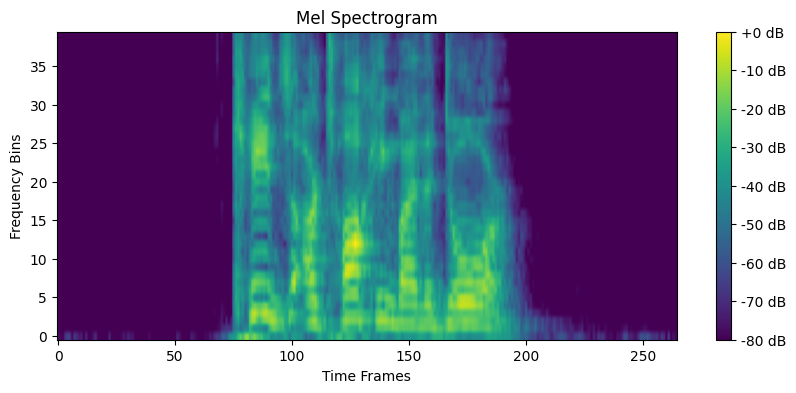

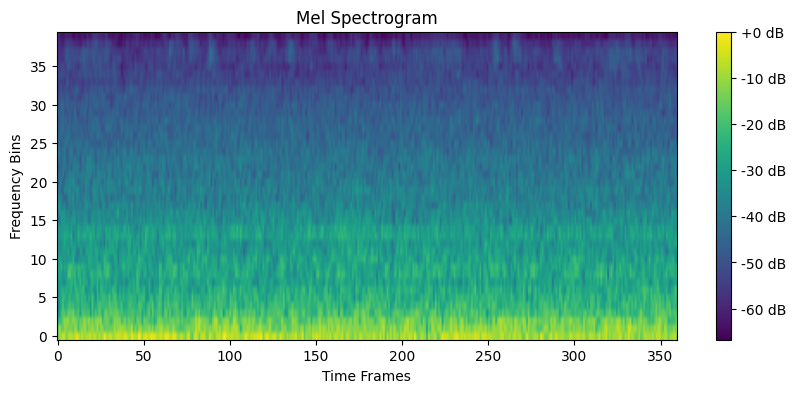

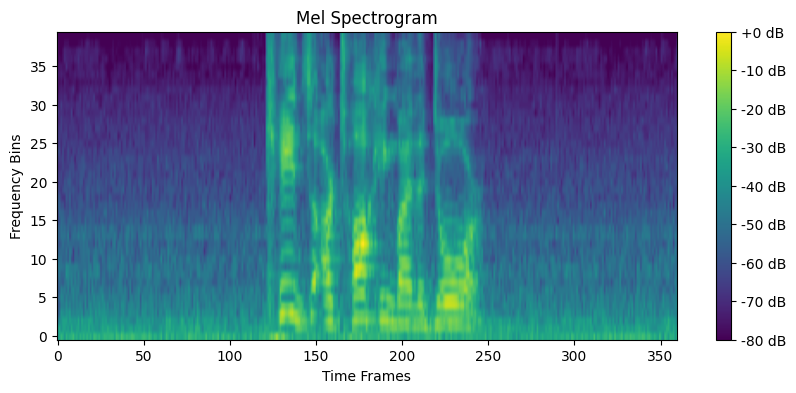

In [19]:
def convertFileToFeatures2(file, truncate_front=False):
    signal, samplerate = librosa.load(file, sr=16000)
    stride_length = compute_stride(len(signal), samplerate, fft_length, 260)
    mfb_features = librosa.feature.melspectrogram(
        y=signal,
        sr=samplerate,
        n_mels=filter_banks,
        n_fft=fft_length,
        hop_length=stride_length,
        win_length=400,
    )
    # converting to decibels is common practice for mfbs
    mfb_features_db = librosa.power_to_db(
        mfb_features, ref=np.max
    )  # need to ask about doing **2 here
    # delta & delta delta
    delta_mfb = librosa.feature.delta(mfb_features_db)
    # delta_delta_mfb = librosa.feature.delta(mfb_features_db, order=2)

    stacked_mfb_features = np.vstack((mfb_features_db, delta_mfb))
    # stacked_mfb_features = np.vstack((mfb_features_db, delta_mfb, delta_delta_mfb))

    # standardize dataset
    # mfb_features_db = preprocessing.scale(mfb_features_db) # need to ask about this
    if truncate_front:
        # mfb_features_db = mfb_features_db[:, ravdess_front_truncate:] # ravdess speakers start late
        stacked_mfb_features = stacked_mfb_features[:, ravdess_front_truncate:]

    if mfb_features_db.shape[1] > desired_windows:
        # mfb_features_db = mfb_features_db[:, :desired_windows]
        stacked_mfb_features = stacked_mfb_features[:, :desired_windows]

    return stacked_mfb_features, stride_length

file_path_ravang = os.path.join(ravdess_train, "03-01-05-02-01-01-11.wav") # ravdess train angry
features_ravang, _ = convertFileToFeatures2(file_path_ravang)
plt.figure(figsize=(10, 4))
mel_features_ravang = features_ravang[:filter_banks, :]
plt.imshow(mel_features_ravang, aspect="auto", origin="lower")
plt.title("Mel Spectrogram")
plt.ylabel("Frequency Bins")
plt.xlabel("Time Frames")
plt.colorbar(format="%+2.0f dB")
plt.show()


file_path_ac = os.path.join(ac_train, "AirConditioner_1_1.wav")
features_ac, _ = convertFileToFeatures(file_path_ac)
plt.figure(figsize=(10, 4))
mel_features_ac = features_ac[:filter_banks, :]
plt.imshow(mel_features_ac, aspect="auto", origin="lower")
plt.title("Mel Spectrogram")
plt.ylabel("Frequency Bins")
plt.xlabel("Time Frames")
plt.colorbar(format="%+2.0f dB")
plt.show()

clean, fs = audioread(file_path_ravang)  # Read the clean speech file
# Add silence to the beginning and end, if required (convert seconds to samples)
silence = np.zeros(int(silence_length * fs))
clean_with_silence = np.concatenate([silence, clean, silence])
# print("fs:", fs, "silence_length:", silence_length," silence:",silence, " clean_with_silence:", clean_with_silence)

# Randomly select a noise file
# noise_filename = random.choice(noisefilenames)
noise, fs = audioread(file_path_ac)  # Read the noise file

# If the noise is shorter than the clean speech, loop it; if it's longer, trim it
if len(noise) < len(clean_with_silence):
    noise = np.tile(noise, int(np.ceil(len(clean_with_silence) / len(noise))))
noise = noise[
    : len(clean_with_silence)
]  # Trim the noise to match the clean speech length

# comment out below if not debugging
# print(f"Clean file {clean_filename}: {len(clean) / fs} seconds")
# print(f"Clean file with silence: {len(clean_with_silence) / fs} seconds")
# print(f"Noise file {noise_filename}: {len(noise) / fs} seconds")

# Mix the clean_with_silence and noise at various SNR levels and write to their respective directories
# for snr in np.linspace(snr_lower, snr_upper, total_snrlevels):
_, _, noisy_snr = snr_mixer(clean_with_silence, noise, 25)

file_name_only = os.path.basename(file_path_ravang)
filename_without_extension, extension = os.path.splitext(file_name_only)

noisyfilename = f"{filename_without_extension}_hello.wav"

# Derive the full paths for the output files
noisypath = os.path.join(noisyfilename)

# Write the output files
audiowrite(noisy_snr, fs, noisypath, norm=False)
file_path_mixed = os.path.join("03-01-05-02-01-01-11_hello.wav")
features_mixed, _ = convertFileToFeatures(file_path_mixed)
plt.figure(figsize=(10, 4))
mel_features_mixed = features_mixed[:filter_banks, :]
plt.imshow(mel_features_mixed, aspect="auto", origin="lower")
plt.title("Mel Spectrogram")
plt.ylabel("Frequency Bins")
plt.xlabel("Time Frames")
plt.colorbar(format="%+2.0f dB")
plt.show()

The below verifies that every utterance has exactly the right number of windows for the same size input to the model.

Ravdess speakers don't begin speaking for about 100 windows in comparison to the other data sets where the speakers talk almost right away. Thus they are truncated 90 windows in the front which is done above

Including ac/bable with test seen in the below

Check for correct dimensions in each set:
Dimensions correct BED_train_features
Dimensions correct BED_testseen_features
Dimensions correct BED_testunseen_features
Dimensions correct CREMAD_train_features
Dimensions correct CREMAD_testseen_features
Dimensions correct CREMAD_testunseen_features
Dimensions correct RAVDESS_train_features
Dimensions correct RAVDESS_testseen_features
Dimensions correct RAVDESS_testunseen_features
Dimensions correct MSSNSD_train_features
Dimensions correct MSSNSD_testseen_features

Utterances in each set:
168 Anger BED_train_features
60 Disgust BED_train_features
82 Fear BED_train_features
84 Happy BED_train_features
108 Neutral BED_train_features
64 Sad BED_train_features
36 Anger BED_testseen_features
6 Disgust BED_testseen_features
22 Fear BED_testseen_features
20 Happy BED_testseen_features
22 Neutral BED_testseen_features
28 Sad BED_testseen_features
50 Anger BED_testunseen_features
26 Disgust BED_testunseen_features
34 Fear BED_testunseen_features
38 H

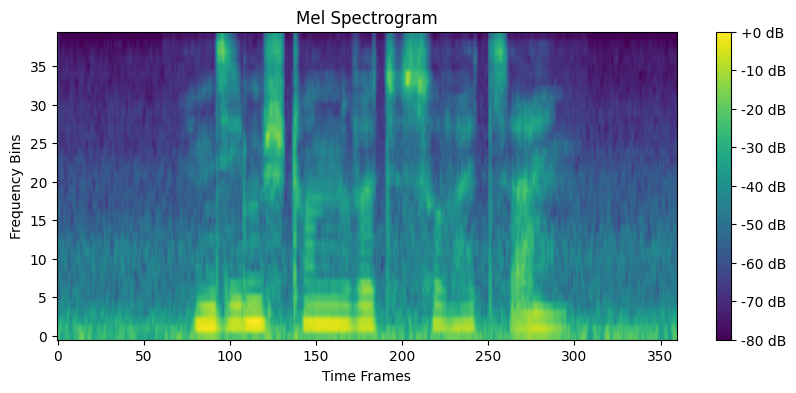

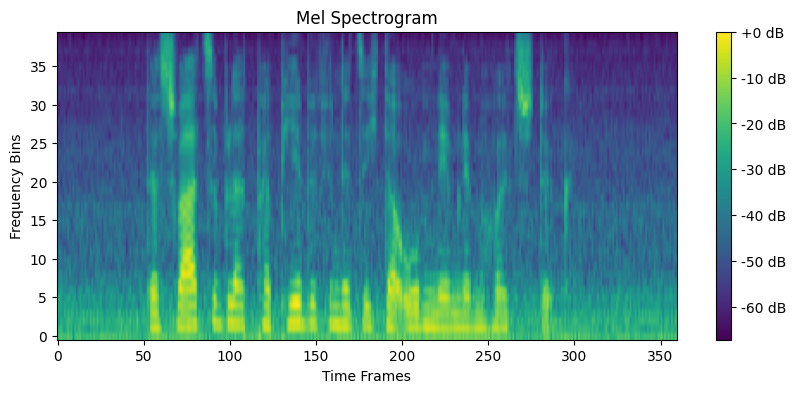

CREMA examples:


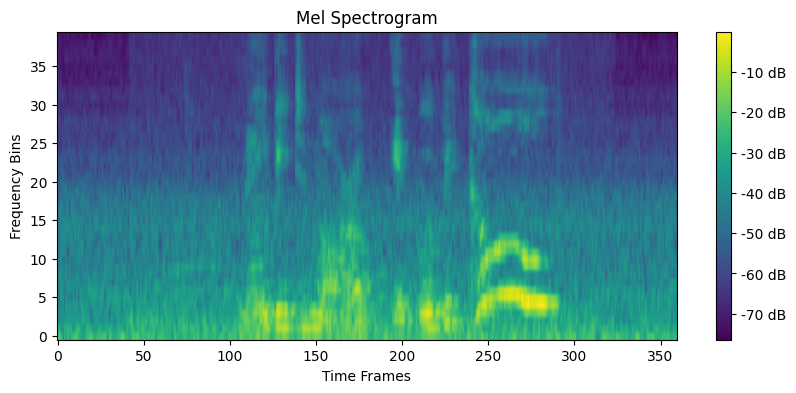

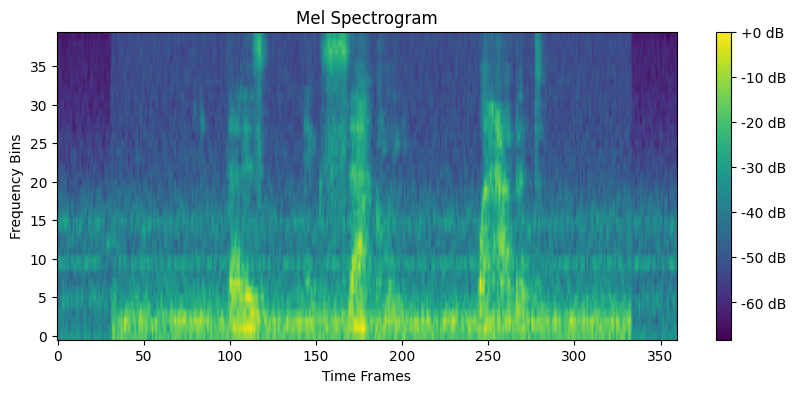

RAVDESS examples:


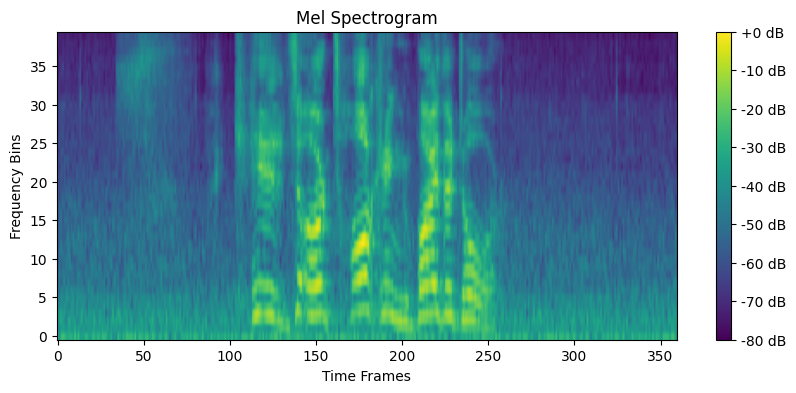

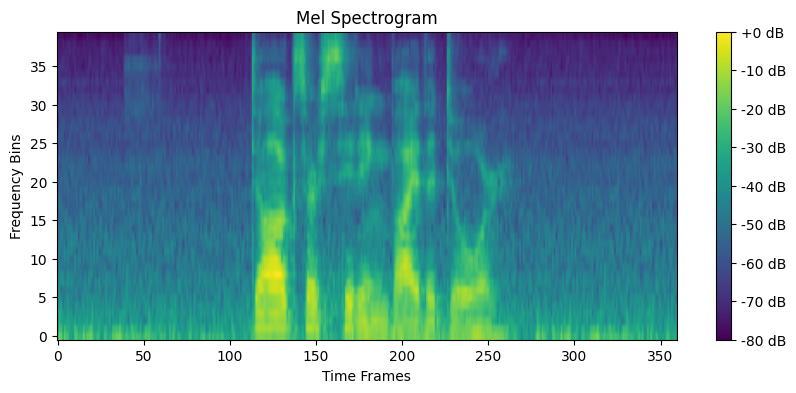

MSSNSD examples:


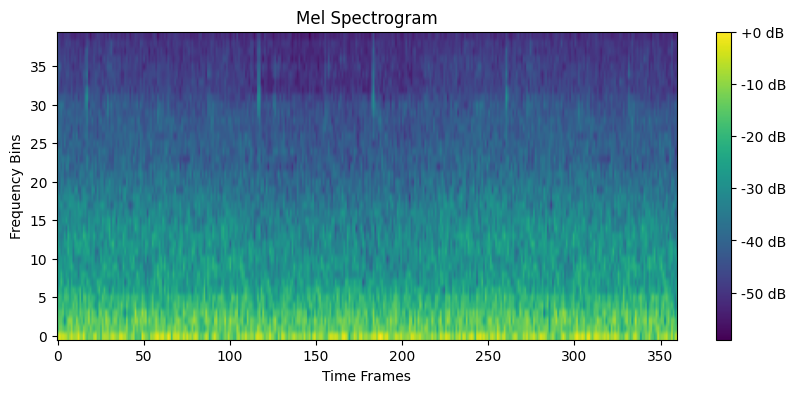

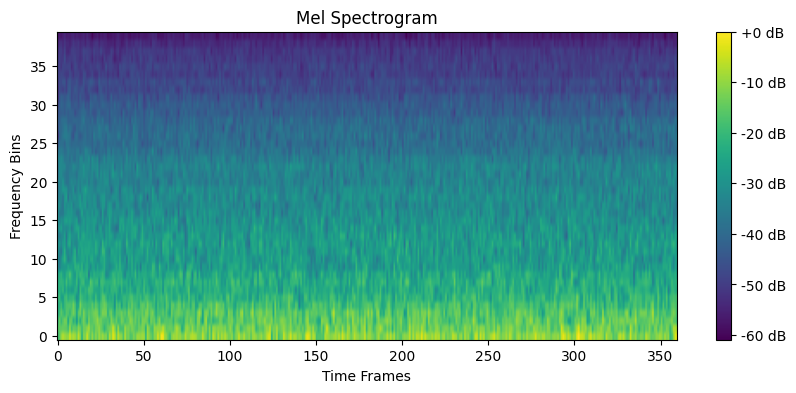

In [13]:
feature_data = {
    "BED_train_features": BED_train_featuredata,
    "BED_testseen_features": BED_test_featuredata_seen,
    "BED_testunseen_features": BED_test_featuredata_unseen,
    "CREMAD_train_features": CREMA_train_featuredata,
    "CREMAD_testseen_features": CREMA_test_featuredata_seen,
    "CREMAD_testunseen_features": CREMA_test_featuredata_unseen,
    "RAVDESS_train_features": RAVDESS_train_featuredata,
    "RAVDESS_testseen_features": RAVDESS_test_featuredata_seen,
    "RAVDESS_testunseen_features": RAVDESS_test_featuredata_unseen,
    "MSSNSD_train_features": MSSNSD_train_featuredata,
    "MSSNSD_testseen_features": MSSNSD_test_featuredata_seen,
}

feature_data_train = {
    "BED_train_features": BED_train_featuredata,
    "CREMAD_train_features": CREMA_train_featuredata,
    "RAVDESS_train_features": RAVDESS_train_featuredata,
    "MSSNSD_train_features": MSSNSD_train_featuredata,
}

feature_data_testseen = {
    "BED_testseen_features": BED_test_featuredata_seen,
    "CREMAD_testseen_features": CREMA_test_featuredata_seen,
    "RAVDESS_testseen_features": RAVDESS_test_featuredata_seen,
    "MSSNSD_testseen_features": MSSNSD_test_featuredata_seen,
}

feature_data_testunseen = {
    "BED_testunseen_features": BED_test_featuredata_unseen,
    "CREMAD_testunseen_features": CREMA_test_featuredata_unseen,
    "RAVDESS_testunseen_features": RAVDESS_test_featuredata_unseen,
}

combined_average_window_count = {
    "BED_train": BED_num_window_train,
    "BED_test_seen": BED_num_window_test_seen,
    "BED_test_unseen": BED_num_window_test_unseen,
    "CREMA_train": CREMA_num_window_train,
    "CREMA_test_seen": CREMA_num_window_test_seen,
    "CREMA_test_unseen": CREMA_num_window_test_unseen,
    "RAVDESS_train": RAVDESS_num_window_train,
    "RAVDESS_test_seen": RAVDESS_num_window_test_seen,
    "RAVDESS_test_unseen": RAVDESS_num_window_test_unseen,
    "MSSNSD_train": MSSNSD_num_window_train,
    "MSSNSD_test_seen": MSSNSD_num_window_test_seen,
}


# check dimensions (same mel filter banks and windows for each utterance after padding/dynamic striding)
def check_dimensions(feature_data):
    for name, data in feature_data.items():
        error = False
        for emotion, values in data.items():
            for arr in values:
                # update features above to match mfbs, delta, delta delta
                if arr.shape[0] != features or arr.shape[1] != desired_windows:
                    print(f"Error {name}")
                    error = True
                    break
            if error:
                break
        if not error:
            print(f"Dimensions correct {name}")


print("Check for correct dimensions in each set:")
check_dimensions(feature_data)

emotion_count = {
    "Sad": 0,
    "Anger": 0,
    "Disgust": 0,
    "Fear": 0,
    "Happy": 0,
    "Neutral": 0,
    "Background": 0,
}

# print data statistics
print()
print("Utterances in each set:")
total_utterances = 0
for dataset_name, data in feature_data.items():
    for emotion, values in data.items():
        count = len(values)
        total_utterances += count
        emotion_count[emotion] += count
        print(f"{count} {emotion} {dataset_name}")

print()
print(f"Total Utterances: {total_utterances}")

print()
print("Number of utterances for each emotion:")
for emotion, count in emotion_count.items():
    percentage = (count / total_utterances) * 100
    print(f"{emotion}: {count}, {percentage:.1f}%")

set_iterated = ["Train", "Seen", "Unseen"]
set_total = {"Train": 0, "Seen": 0, "Unseen": 0}

for i, set_ttt in enumerate(
    [feature_data_train, feature_data_testseen, feature_data_testunseen]
):
    print()
    print(f"Number of utterances for each emotion in {set_iterated[i]}:")
    set_utterances = 0
    emotion_count2 = {
        "Sad": 0,
        "Anger": 0,
        "Disgust": 0,
        "Fear": 0,
        "Happy": 0,
        "Neutral": 0,
        "Background": 0,
    }
    for dataset_name, data in set_ttt.items():
        for emotion, values in data.items():
            count = len(values)
            set_utterances += count
            emotion_count2[emotion] += count
    for emotion, count in emotion_count2.items():
        percentage = (count / set_utterances) * 100
        print(f"{emotion}: {count}, {percentage:.1f}%")
    set_total[set_iterated[i]] = set_utterances

print()
print("Number of utterances for each set:")
for set_ttt, count in set_total.items():
    percentage = (count / total_utterances) * 100
    print(f"{set_ttt}: {count}, {percentage:.1f}%")

print()
print("Average number of windows:")
for dataset_name, data in combined_average_window_count.items():
    print(f"{data} {dataset_name}")

print()
print(f"Aggregate average number of windows: {np.mean(all_num_window)}")

hop_mean = statistics.mean(all_stride_length)
hop_sd = statistics.stdev(all_stride_length)
print()
print(f"Hop Length mean: {hop_mean}")
print(f"Hop Length standard deviation: {hop_sd}")

def plot_spectogram(mel_spectrogram):
    plt.figure(figsize=(10, 4))
    mel_features = mel_spectrogram[:filter_banks, :]
    plt.imshow(mel_features, aspect="auto", origin="lower")
    plt.title("Mel Spectrogram")
    plt.ylabel("Frequency Bins")
    plt.xlabel("Time Frames")
    plt.colorbar(format="%+2.0f dB")
    plt.show()

print()
print("Example MFBs after padding:")
print("BED examples:")
mel_spectrogram = BED_train_featuredata["Sad"][0]
plot_spectogram(mel_spectrogram)
mel_spectrogram = BED_train_featuredata["Neutral"][4]
plot_spectogram(mel_spectrogram)
print("CREMA examples:")
mel_spectrogram = CREMA_train_featuredata["Happy"][6]
plot_spectogram(mel_spectrogram)
mel_spectrogram = CREMA_train_featuredata["Disgust"][10]
plot_spectogram(mel_spectrogram)
print("RAVDESS examples:")
mel_spectrogram = RAVDESS_train_featuredata["Anger"][30]
plot_spectogram(mel_spectrogram)
mel_spectrogram = RAVDESS_train_featuredata["Neutral"][16]
plot_spectogram(mel_spectrogram)
print("MSSNSD examples:")
mel_spectrogram = MSSNSD_train_featuredata["Background"][2]
plot_spectogram(mel_spectrogram)
mel_spectrogram = MSSNSD_train_featuredata["Background"][105]
plot_spectogram(mel_spectrogram)

In [16]:
# export in .npy files for easy access to the model

data_path = "dataformodel"

BED_train_features = []
BED_testseen_features = []
BED_testunseen_features = []
CREMAD_train_features = []
CREMAD_testseen_features = []
CREMAD_testunseen_features = []
RAVDESS_train_features = []
RAVDESS_testseen_features = []
RAVDESS_testunseen_features = []
MSSNSD_train_features = []
MSSNSD_testseen_features = []
BED_train_labels = []
BED_testseen_labels = []
BED_testunseen_labels = []
CREMAD_train_labels = []
CREMAD_testseen_labels = []
CREMAD_testunseen_labels = []
RAVDESS_train_labels = []
RAVDESS_testseen_labels = []
RAVDESS_testunseen_labels = []
MSSNSD_train_labels = []
MSSNSD_testseen_labels = []

to_save = {
    "BED_train_features": [BED_train_features, BED_train_labels],
    "BED_testseen_features": [BED_testseen_features, BED_testseen_labels],
    "BED_testunseen_features": [BED_testunseen_features, BED_testunseen_labels],
    "CREMAD_train_features": [CREMAD_train_features, CREMAD_train_labels],
    "CREMAD_testseen_features": [CREMAD_testseen_features, CREMAD_testseen_labels],
    "CREMAD_testunseen_features": [CREMAD_testunseen_features, CREMAD_testunseen_labels],
    "RAVDESS_train_features": [RAVDESS_train_features, RAVDESS_train_labels],
    "RAVDESS_testseen_features": [RAVDESS_testseen_features, RAVDESS_testseen_labels],
    "RAVDESS_testunseen_features": [RAVDESS_testunseen_features, RAVDESS_testunseen_labels],
    "MSSNSD_train_features": [MSSNSD_train_features, MSSNSD_train_labels],
    "MSSNSD_testseen_features": [MSSNSD_testseen_features, MSSNSD_testseen_labels]
}

for key, value in to_save.items():
    features = feature_data[key]
    for emotion, arrs in features.items():
        for arr in arrs:
            value[0].append(arr)
            value[1].append(emotion)

os.makedirs(data_path, exist_ok=True)
for key, value in to_save.items():
    parts = key.split("_")
    path_features = os.path.join(data_path, f"{parts[0]}_{parts[1]}_features.npy")
    path_labels = os.path.join(data_path, f"{parts[0]}_{parts[1]}_labels.npy")
    np.save(path_features, np.array(value[0]))
    np.save(path_labels, np.array(value[1]))